Look at the results of adding climate data and see the differential performance on samples with satellite imagery samples with only climate data

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import shutil
import yaml

from cloudpathlib import AnyPath
import lightgbm as lgb
import pandas as pd
from zipfile import ZipFile

from cyano.evaluate import (
    EvaluatePreds,
    generate_and_plot_crosstab,
    generate_actual_density_boxplot,
    generate_regional_barplot,
)

In [3]:
s3_dir = AnyPath("s3://drivendata-competition-nasa-cyanobacteria/experiments")

In [4]:
# load ground truth
true_path = s3_dir / "splits/competition/test.csv"
true = pd.read_csv(true_path, index_col=0)
true.shape

(6510, 8)

In [5]:
# load predictions
preds = pd.read_csv(
    s3_dir / "results/third_sentinel_and_climate/preds.csv", index_col=0
)
preds.shape

(6510, 4)

In [6]:
preds.isna().sum()

date            0
latitude        0
longitude       0
severity     1050
dtype: int64

### Save out subsets with / without satellite imagery

So that we can instantiate separate `EvaluatePreds` classes, save out two versions of the predictions -- one with only samples that have satellite imagery, one with only samples that *don't* have satellite imagery

In [7]:
# Load test features to see which samples had satellite imagery
test_features = pd.read_csv(
    s3_dir / "results/third_sentinel_and_climate/features_test.csv"
)
test_features.shape, test_features.sample_id.nunique()

((22128, 74), 5460)

In [8]:
test_features.head(2)

,sample_id,AOT_mean,AOT_min,AOT_max,AOT_range,B01_mean,B01_min,B01_max,B01_range,B02_mean,...,NDVI_B07,month,days_before_sample,TMP_min,TMP_mean,TMP_max,SPFH_min,SPFH_mean,SPFH_max,rounded_longitude
0,00028d54fa33b3b90a70eda38c1d94c4,126.0,126.0,126.0,0.0,685.530612,432.0,1742.0,1310.0,822.126417,...,0.029072,9.0,6.0,288.82895,290.581756,292.12683,0.00823,0.010754,0.01257,-12.0
1,00028d54fa33b3b90a70eda38c1d94c4,114.0,114.0,114.0,0.0,643.408163,351.0,1668.0,1317.0,819.565760,...,0.019663,9.0,11.0,288.82895,290.581756,292.12683,0.00823,0.010754,0.01257,-12.0


In [9]:
test_features.isna().sum()

sample_id              0
AOT_mean             636
AOT_min              636
AOT_max              636
AOT_range            636
                    ... 
TMP_max               25
SPFH_min              25
SPFH_mean             25
SPFH_max              25
rounded_longitude      0
Length: 74, dtype: int64

In [10]:
# all satellite features have the same number of missing values
test_features.isna().sum().value_counts()

636    66
25      6
0       2
Name: count, dtype: int64

In [11]:
test_features["has_climate"] = test_features.SPFH_max.notna()
test_features["has_satellite"] = test_features.AOT_mean.notna()

# how many samples have climate features?
test_features[test_features.has_climate].sample_id.nunique()

5444

In [12]:
# how many samples have satellite features?
test_features[test_features.has_satellite].sample_id.nunique()

4824

In [13]:
# all sample have either satellite or climate
test_features.groupby(
    ["has_climate", "has_satellite"], as_index=False
).sample_id.nunique()

,has_climate,has_satellite,sample_id
0,False,True,16
1,True,False,636
2,True,True,4808


In [14]:
tmp_save_dir = AnyPath("tmp_data")
tmp_save_dir.mkdir(exist_ok=True, parents=True)

preds_sat_path = tmp_save_dir / "preds_with_sat.csv"
preds_no_sat_path = tmp_save_dir / "preds_no_sat.csv"

In [15]:
# Save out subset with satellite imagery
preds_sat = preds.loc[test_features[test_features.has_satellite].sample_id.unique()]
print(preds_sat.shape)
preds_sat.to_csv(preds_sat_path, index=True)

(4824, 4)


In [16]:
# Save out subset without satellite imagery
preds_no_sat = preds.loc[test_features[~test_features.has_satellite].sample_id]
print(preds_no_sat.shape)
preds_no_sat.to_csv(preds_no_sat_path, index=True)

(636, 4)


In [17]:
# Load model
archive = ZipFile(s3_dir / "results/third_sentinel_and_climate/model.zip", "r")
model = lgb.Booster(model_str=archive.read("lgb_model.txt").decode())
type(model)

lightgbm.basic.Booster

### Instantiate `EvaluatePreds` classes

In [18]:
evals = {}
evals["with_satellite"] = EvaluatePreds(
    true_path, preds_sat_path, "tmp/eval_sat", model
)

2023-08-23 10:31:26.204 | INFO     | cyano.evaluate:__init__:98 - Evaluating on 4,824 samples (of 4,824)


In [19]:
evals["without_satellite"] = EvaluatePreds(
    true_path, preds_no_sat_path, "tmp/eval_sat", model
)

2023-08-23 10:31:26.408 | INFO     | cyano.evaluate:__init__:98 - Evaluating on 636 samples (of 636)


## Evaluate

In [20]:
import matplotlib.pyplot as plt

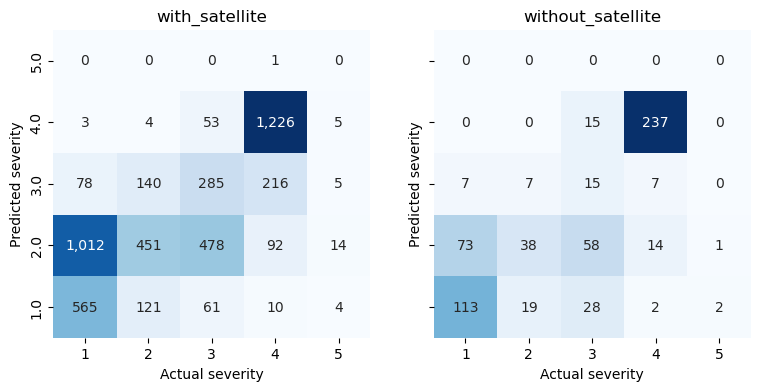

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for i, key in enumerate(evals.keys()):
    generate_and_plot_crosstab(evals[key].y_true, evals[key].y_pred, ax=axes[i])
    axes[i].set_title(key)

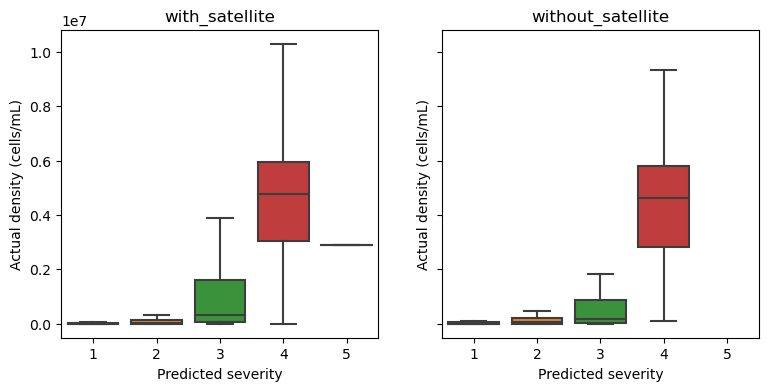

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for i, key in enumerate(evals.keys()):
    generate_actual_density_boxplot(
        evals[key].metadata.density_cells_per_ml, evals[key].y_pred, ax=axes[i]
    )
    axes[i].set_title(key)

In [23]:
results = {key: evalpreds.calculate_metrics() for key, evalpreds in evals.items()}

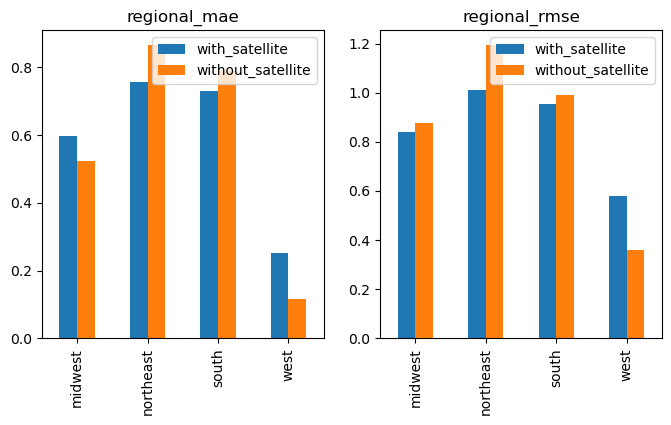

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, metric in enumerate(
    [
        "regional_mae",
        "regional_rmse",
    ]
):
    regional_scores = pd.DataFrame({key: res[metric] for key, res in results.items()})
    regional_scores.plot(kind="bar", ax=axes[i])
    axes[i].set_title(metric)
plt.show()

In [25]:
# See RMSE in detail for regions
regional_scores

,with_satellite,without_satellite
midwest,0.838046,0.874700
northeast,1.012438,1.194467
south,0.952904,0.991903
west,0.577350,0.361382


In [26]:
pd.DataFrame(results).T[
    [
        "overall_rmse",
        "overall_mae",
        "overall_mape",
        "region_averaged_rmse",
    ]
]

,overall_rmse,overall_mae,overall_mape,region_averaged_rmse
with_satellite,0.826213,0.539594,0.342354,0.845185
without_satellite,0.826069,0.462264,0.244418,0.855613


**Takeaway**

The difference in performance between samples with and without satellite imagery is not huge. Samples without satellite imagery have noticeably higher RMSE in the northeast and a small amount higher in the midwest and south, but actually lower RMSE in the west.

The difference in performance is much greater when looking at MAE and MAPE than when looking at RMSE.

In [27]:
feature_importance = pd.read_csv(
    s3_dir / "results/third_sentinel_and_climate/metrics/feature_importance.csv",
    index_col=0,
)

# what are the top features by importance gain?
feature_importance.sort_values(by="importance_gain", ascending=False).head(10)

,importance_gain,importance_split
feature,,
rounded_longitude,202955.651685,566
TMP_max,14037.840122,1642
month,11736.040193,648
TMP_min,8056.240197,1528
TMP_mean,7514.781976,1430
SPFH_min,7293.962607,1573
SPFH_max,6980.449090,1388
SPFH_mean,6250.482605,1203
B05_min,2693.146313,340


In [28]:
# what are the top features by importance split?
feature_importance.sort_values(by="importance_split", ascending=False).head(10)

,importance_gain,importance_split
feature,,
TMP_max,14037.840122,1642
SPFH_min,7293.962607,1573
TMP_min,8056.240197,1528
TMP_mean,7514.781976,1430
SPFH_max,6980.449090,1388
SPFH_mean,6250.482605,1203
NDVI_B07,1964.771477,1003
NDVI_B06,1694.195924,739
month,11736.040193,648


**Takeaways**

All of our climate features are in the top most important features. Even though performance is somewhat lower on data with no satellite imagery, this implies that the model is still able to glean useful information with climate data alone.

In [29]:
# delete temporary dir
shutil.rmtree(tmp_save_dir)